In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms, datasets
import torch.backends.cudnn as cudnn

import time
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy.special import softmax

from networks import ResNet
from utils import *
from utils_plotting import *
import tent

In [2]:
print(torch.cuda.is_available())
use_cuda = torch.cuda.is_available()

print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True
0
1
NVIDIA GeForce GTX 1070


In [3]:
batch_size = 128
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
                                    ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

print(trainset.train_data.shape)

models_dir = "Models/" + 'Tent_models'
results_dir = "Results/" + 'Tent_results'

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


## Network

In [5]:
model = ResNet(18,10)
model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))

print(sum(p.numel() for p in model.parameters())/1000000, "M parameters")

# TENT

model = tent.configure_model(model)
params, param_names = tent.collect_params(model)
# optimizer = torch.optim.Adam(params, lr=1e-1)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=5e-4)

tented_model = tent.Tent(model, optimizer)
# tented_model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))

tented_model = tented_model.to(device)

0.175818 M parameters


## Inference

### Rotations

In [6]:
data_rotated = np.load("data/CIFAR10_rotated.npy")
# data_rotated = np.transpose(data_rotated, (0,1,4,2,3))
data_rotated.shape

(16, 10000, 32, 32, 3)

In [13]:
steps = 16
N = 10000
Nsamples = 3
y_dev = valset.test_labels

def preprocess_test(X):

    N, H, W, C = X.shape
    Y = torch.zeros(N, C, H, W)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)  
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    for n in range(len(X)):
        Y[n] =  transform_test(X[n])

    return Y

all_preds = np.zeros((N, steps, 10))
all_sample_preds = np.zeros((N, Nsamples, steps, 10))

for im_ind in range(N):
    if(im_ind % 500 == 0):
        print(im_ind)

    y =  y_dev[im_ind]
    
    ims = data_rotated[:,im_ind,:,:,:]
    ims = preprocess_test(ims)
    # print(ims.shape)

    y = np.ones(ims.shape[0])*y
    
    # sample_probs = tented_model.all_sample_eval(ims, torch.from_numpy(y), Nsamples=Nsamples)

    predictions = torch.zeros(Nsamples, steps, 10)

    ims = ims.to(device)
    for i in range(Nsamples):
        y = tented_model(ims)
        # print(y.shape)
        predictions[i] = y

    probs = F.softmax(predictions, dim=2)
    probs = probs.detach().numpy()

    all_sample_preds[im_ind] = probs
    all_preds[im_ind] = np.mean(probs, axis=0)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


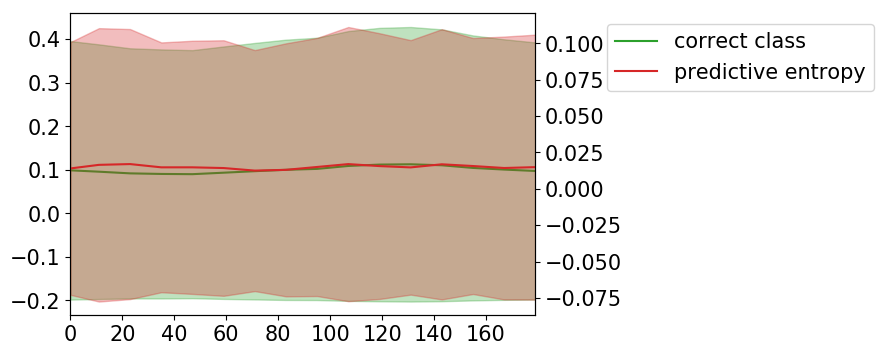

In [14]:
rotations = (np.linspace(0, 179, steps)).astype(int)

correct_preds = np.zeros((N, steps))
for i in range(N):
    correct_preds[i,:] = all_preds[i,:,y_dev[i]]   

np.save(results_dir+'/correct_preds.npy', correct_preds)
np.save(results_dir+'/all_preds.npy', all_preds)
np.save(results_dir+'/all_sample_preds.npy', all_sample_preds)

plot_predictive_entropy(correct_preds, all_preds, rotations, results_dir)

In [17]:
preds = np.argmax(all_preds[:,0,:],axis=1)
print(preds[:100],valset.test_labels[:100])

[5 8 1 8 4 6 9 2 3 9 3 9 5 7 1 1 7 1 3 2 3 4 3 0 3 3 4 1 7 1 1 1 2 3 2 3 3
 7 3 1 7 3 3 7 7 7 3 7 7 1 1 7 7 3 2 7 3 7 1 1 1 3 7 7 1 1 7 7 3 1 7 7 7 7
 7 1 7 1 3 7 7 7 7 3 3 3 3 7 7 7 7 1 3 3 3 3 3 7 3 7] [3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7]


In [18]:
print(np.mean(preds == valset.test_labels))

0.099


### CIFAR10-C

In [56]:
model = ResNet(18,10)
model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))
# checkpoint = torch.load(models_dir + '/' + 'theta_best.t7')
# model = checkpoint['net']

print(sum(p.numel() for p in model.parameters())/1000000, "M parameters")

# TENT

model = tent.configure_model(model)
params, param_names = tent.collect_params(model)
# optimizer = torch.optim.Adam(params, lr=1e-1)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=5e-4)

tented_model = tent.Tent(model, optimizer)
# tented_model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))

tented_model = tented_model.to(device)

0.175818 M parameters


In [66]:
# model = ResNet(18,10).to(device)
# model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))
# checkpoint = torch.load(models_dir + '/' + 'theta_best.t7')
# model = checkpoint['net']

chalPath = 'data/CIFAR-10-C/'
chals = sorted(os.listdir(chalPath))

chal_labels = valset.test_labels
chal_labels = torch.Tensor(chal_labels)
chal_labels = chal_labels.long()

Nsamples = 10

def preprocess_test(X):

    N, H, W, C = X.shape
    Y = torch.zeros(N, C, H, W)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)  
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    for n in range(len(X)):
        Y[n] =  transform_test(X[n])

    return Y

preds_list= []
# net.eval()
avg_list = []

for challenge in range(len(chals)):
    chal_data = np.load(chalPath + chals[challenge])
    # chal_data = np.transpose(chal_data, (0,3,1,2))

    avg = 0
    for j in range(5):

        # Get Tented Model
        model = ResNet(18,10)
        model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))

        model = tent.configure_model(model)
        params, param_names = tent.collect_params(model)
        optimizer = torch.optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=5e-4)
        tented_model = tent.Tent(model, optimizer)
        # tented_model.load_state_dict(torch.load(models_dir + '/' + 'theta_best.pt'))
        tented_model = tented_model.to(device)

        # Load CIFAR10-C Data
        chal_temp_data = chal_data[j * 10000:(j + 1) * 10000]
        chal_temp_data = preprocess_test(chal_temp_data)

        chal_dataset = torch.utils.data.TensorDataset(chal_temp_data, chal_labels)
        chal_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=100)
        chal_error = 0

        correct = 0
        with torch.no_grad():
            for x, y in chal_loader:
                # cost, err, probs = net.sample_eval(x, y, Nsamples=10, logits=False)
                # preds_list.append(probs.cpu().numpy())
                # chal_error += err.cpu().numpy()
                x = x.to(device)
                predictions = torch.zeros(Nsamples, 100, 10)
                for i in range(Nsamples):
                    outputs = tented_model(x)
                    # print(y.shape)
                    predictions[i] = F.softmax(outputs, dim=1)
                
                preds = predictions.mean(0)
                preds_list.append(preds.cpu().numpy())
                correct += torch.sum(torch.argmax(preds,1) == y)
            # print(err)

        # print(chal_error)
        chal_acc = (correct/len(chal_dataset)).item()
        avg += chal_acc
        print(round(chal_acc,4))
    
    avg /= 5
    avg_list.append(avg)
    print("Average:", round(avg,4)," ", chals[challenge])

print("Mean: ", np.mean(avg_list))

0.2276
0.2179
0.1843
0.2514
0.2366
Average: 0.2236   brightness.npy
0.2299
0.1446
0.2273
0.2084
0.1884
Average: 0.1997   contrast.npy
0.2547
0.2065
0.2128
0.2143
0.1732
Average: 0.2123   defocus_blur.npy
0.1994
0.2053
0.2101
0.1784
0.1787
Average: 0.1944   elastic_transform.npy
0.2736
0.2214
0.2646
0.1906
0.205
Average: 0.231   fog.npy
0.2012
0.2153
0.168
0.1684
0.125
Average: 0.1756   frost.npy
0.2331
0.2198
0.2142
0.2198
0.1867
Average: 0.2147   gaussian_blur.npy
0.1679
0.2002
0.2168
0.1708
0.2339
Average: 0.1979   gaussian_noise.npy
0.141
0.1936
0.1744
0.1392
0.1522
Average: 0.1601   glass_blur.npy
0.1811
0.1556
0.1593
0.1624
0.1712
Average: 0.1659   impulse_noise.npy
0.1974
0.1816
0.2131
0.1828
0.1494
Average: 0.1849   jpeg_compression.npy
0.1792
0.1684
0.1513
0.1986
0.1709
Average: 0.1737   motion_blur.npy
0.1965
0.1919
0.2113
0.2024
0.1662
Average: 0.1937   pixelate.npy
0.2421
0.1944
0.2636
0.2607
0.2097
Average: 0.2341   saturate.npy
0.2267
0.1668
0.1781
0.2086
0.178
Average: 0.

In [67]:
preds_list1 = np.vstack(preds_list)
preds_list1.shape

(950000, 10)

In [ ]:
np.save(results_dir+'/preds_CIFAR-10-C.npy', preds_list1)
np.save(results_dir+'/avg_list_CIFAR-10-C.npy', avg_list)